In [1]:
from geometry import *
import numpy as np
import pypower
import scipy.optimize as opt

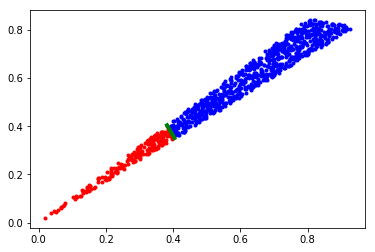

In [2]:
# check (visually) the computation of the intersection between a triangle and a quadric

import matplotlib.pyplot as plt
%matplotlib inline

# quad(x,y,z) = -x^2 - y^2 + z
# quad >= if z >= x^2 + y^2
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), -1)

above = np.array([0,0,2])
v = np.random.rand(3)
w = np.random.rand(3)
    
def trisample(A, B, C,N):
    r1 = np.random.rand(N)
    r2 = np.random.rand(N)
    s1 = np.sqrt(r1)

    X = np.zeros((N,3))
    X[:,0] = A[0] * (1.0 - s1) + B[0] * (1.0 - r2) * s1 + C[0] * r2 * s1
    X[:,1] = A[1] * (1.0 - s1) + B[1] * (1.0 - r2) * s1 + C[1] * r2 * s1
    X[:,2] = A[2] * (1.0 - s1) + B[2] * (1.0 - r2) * s1 + C[2] * r2 * s1
    return X

X = trisample(above,v,w,1000)
s = np.array([quad(x) for x in X])
plt.plot(X[s>0,0], X[s>0,1],'.r')
plt.plot(X[s<0,0], X[s<0,1],'.b')

curves = intersect_triangle_with_quadric(quad, v, w, above)
for c in curves:
    plt.plot(c[:,0], c[:,1],'g', linewidth=4)


3.9999985564626948


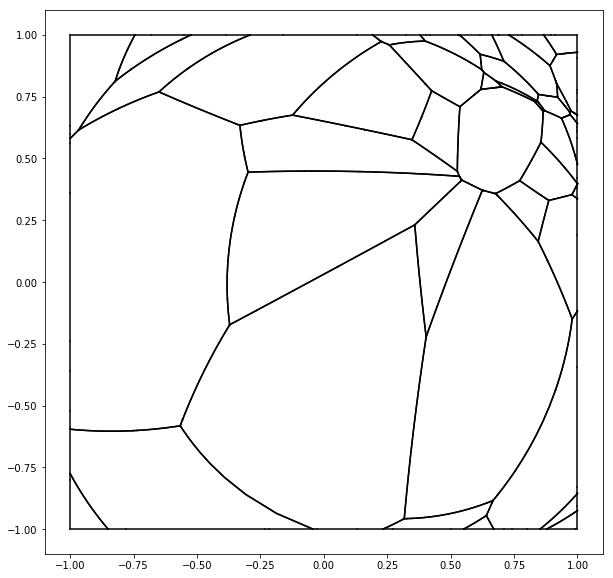

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)

N=100
X = np.random.rand(N,3)
w = np.zeros(N)
cells = pypower.power_diagram(X,w)

area = 0
plt.figure(figsize=(10,10))
for i in range(N):
    curves = intersect_cell_with_quadric(X,cells[i],quad,20)
    if curves is None:
        print("empty cell {}".format(i))
        continue
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], 'k')
print(area)

In [4]:
def area_of_cell(curves):
    if curves is None:
        return 0.0
    area = 0.0
    # compute area of cell i by integrating over the boundary
    # j is the number of the adjacent cell (negative number if adjacency 
    # is with the boundary)
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for k in range(crv.shape[0]-1):
                a = crv[k,0:2]
                b = crv[k+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
    return area

def areas_of_power_diagram_quadric_intersection(X,w,quad):
    cells = pypower.power_diagram(X,w)
    areas = [area_of_cell(intersect_cell_with_quadric(X,c,quad,20)) for c in cells]
    return np.array(areas)
 
N = 10
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)
X = np.random.rand(N,3)
w = np.zeros(N)
H = lambda w: areas_of_power_diagram_quadric_intersection(X,w,quad)
H(w)

array([0.02180148, 0.00658023, 0.        , 0.78090292, 2.1214453 ,
       0.17605371, 0.        , 0.24984005, 0.59241797, 0.05097992])

In [ ]:

def enlarge(x):
    z = np.zeros(len(x)+1)
    z[1:] = x
    return z
x = opt.fsolve(lambda x: (H(enlarge(x)) - 4/N)[1:], np.zeros(N-1))
w = enlarge(x)

In [9]:
# Oliker-Prussner
N = 10
X = np.random.rand(N,3)
w = np.zeros(N)
w[0] = 5
delta = 0.35
nu = 4*np.ones(N)/N

def H(w):
    return areas_of_power_diagram_quadric_intersection(X,w,quad)
def Hi(w,i):
    cells = pypower.power_diagram(X,w)
    return area_of_cell(intersect_cell_with_quadric(X,cells[i],quad,20))
def e(i):
    x = np.zeros(N)
    x[i] = 1
    return x
    
while delta>0.01:
    print("delta={}".format(delta))
    good = False
    while not good:
        good = True
        t = np.zeros(N)
        for i in range(1,N):
            if Hi(w,i) >= nu[i] - delta:
                continue
            f = lambda s: Hi(w+s*e(i),i) - nu[i]
            # cell i does not have enough mass: we need to increase w
            t[i] = opt.root_scalar(f, bracket=[0,10]).root
            good = False
        print(np.linalg.norm(H(w) - 4/N))
        w = w + t
    delta /= 2

delta=0.35
3.7947331922020573
1.2310807816614404
1.1518272635048292
delta=0.0875
len(T) = 1 -0.494715844164932 1.4358431144056993e-07
len(T) = 1 1.4358431144056993e-07 -0.6154508815807045
len(T) = 1 -0.494715835064812 4.0941229073609975e-08
len(T) = 1 4.0941229073609975e-08 -0.615450842889441
len(T) = 1 -0.4947158322707672 9.426334601769781e-09
len(T) = 1 9.426334601769781e-09 -0.6154508310099158
len(T) = 1 -0.49471583366778993 2.518378416915823e-08
len(T) = 1 2.518378416915823e-08 -0.6154508369496792
len(T) = 1 -0.4947158343663003 3.30625065103618e-08
len(T) = 1 3.30625065103618e-08 -0.61545083991956
len(T) = 1 -0.49471583393736673 2.822442746186482e-08
len(T) = 1 2.822442746186482e-08 -0.6154508380958483
len(T) = 1 -0.4947158337718274 2.635726015220996e-08
len(T) = 1 2.635726015220996e-08 -0.6154508373920202
len(T) = 1 -0.4947158338545967 2.7290844029081995e-08
len(T) = 1 2.7290844029081995e-08 -0.6154508377439343
len(T) = 1 -0.49471583380377093 2.6717558054834e-08
len(T) = 1 2.67175

In [6]:
H(w)

array([0.38352843, 0.39524207, 0.39177155, 0.39026673, 0.39457323,
       0.39582867, 0.39022906, 0.39332245, 0.46543883, 0.4       ])